In [2]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

## compare to coupler-free structrue

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8000.0MHz', 'Q2_anhar': '-150.0MHz', 'g12': '34.641MHz'}


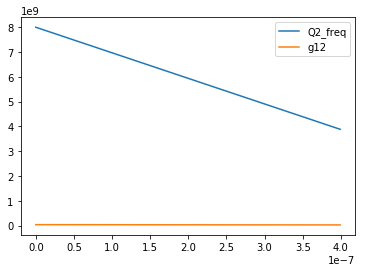

In [160]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=2,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/6.8,4/6.8,400)
freq_array = 7.8e9-flux_pulse * (7.8e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.0e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)

raw_config.setValue('r12',0.005)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

In [165]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=10e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('11-10-01+00')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [164]:
%matplotlib qt

In [156]:
eigen_trace[0]

-238433.50989331177

In [7]:
%matplotlib inline

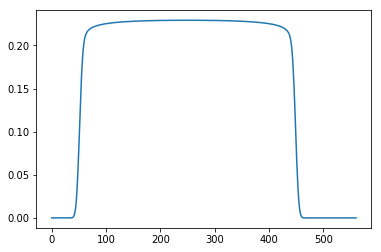

In [72]:
gate_time,SRATE,f_term,factor_r,T_reflec=(40e-9,10e9,1,0,2e-9)
lamb1 = [0.8]
total_len = gate_time + 8e-9+4*T_reflec


Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Slepian',t0=gate_time/2+10e-9/2,width=gate_time,amplitude=10e6,plateau=0e-9,frequency=0,F_Terms=2,Lcoeff=np.array([1,0.1]),
              Coupling=20e6,Offset=1.5e9,dfdV=6.5e9,negative_amplitude=True)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflec))
flux_pulse2=Seq.get_sequence()

plt.plot(flux_pulse2)
# plt.plot(flux_pulse2)

In [158]:

def cost_func_05(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflec=args
    lamb1 = pulse_params
    print(lamb1)
    
    total_len = gate_time + 8e-9+4*T_reflec
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Slepian',t0=gate_time/2+10e-9/2,width=gate_time,amplitude=lamb1[0],plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([0.3]),
                  Coupling=30.65e6*np.sqrt(2),Offset=1.75e9,dfdV=7e9,negative_amplitude=True)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflec))
    flux_pulse=Seq.get_sequence()

#     print(flux_pulse[int(len(flux_pulse)/2)-5:int(len(flux_pulse)/2)])
    
    raw_config = Circuit_Simulator.RawConfig(qubit_num=2,dimension=3,circuit_type=1,initial_state='-Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',8e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.25e9)
    raw_config.setValue('r12',0.005)

    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0.00)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['00','01','10','11'])
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity
    print('error:',1-fidelity)
    return 1 - fidelity


def cost_func(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflec=args
    lamb1 = pulse_params
    print(lamb1)
    
    total_len = gate_time + 8e-9+4*T_reflec
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Slepian',t0=gate_time/2+10e-9/2,width=gate_time,amplitude=lamb1[0],plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([0.3]),
                  Coupling=12.25e6*np.sqrt(2),Offset=1.25e9,dfdV=6.5e9,negative_amplitude=True)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflec))
    flux_pulse=Seq.get_sequence()

#     print(flux_pulse[int(len(flux_pulse)/2)-5:int(len(flux_pulse)/2)])
    
    raw_config = Circuit_Simulator.RawConfig(qubit_num=2,dimension=3,circuit_type=1,initial_state='-Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.5e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.25e9)
    raw_config.setValue('r12',0.002)

    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0.00)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['00','01','10','11'])
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity
    print('error:',1-fidelity)
    return 1 - fidelity

In [ ]:
SRATE=6e9
gate_time=30e-9
f_terms=1
T_r=5e-9

factor_r_arr = np.linspace(-0.1,0.1,41) 
# factor_r_arr = np.linspace(0.055,0.1,10)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([10e6])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':20})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x
    raw_initial_seeds = DATA.x
    
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_coupling_strength\param_30ns_no_coupler_r12_002.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_coupling_strength\error_30ns_no_coupler_r12_002.txt',gate_fidelity_one )
    jj+=1

In [159]:
SRATE=6e9
gate_time=30e-9
f_terms=1
T_r=5e-9

factor_r_arr = np.linspace(-0.1,0.1,41) 
# factor_r_arr = np.linspace(0.055,0.1,10)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([10e6])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_05,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':20})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x
    raw_initial_seeds = DATA.x
    
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_coupling_strength\param_30ns_no_coupler_r12_005.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_coupling_strength\error_30ns_no_coupler_r12_005.txt',gate_fidelity_one )
    jj+=1

[10000000.]
error: 0.2460046780732994
[10500000.]
error: 0.2369080030434807
[11000000.]
error: 0.22802061410154273
[11500000.]
error: 0.21935973645844464
[12500000.]
error: 0.2027842368123317
[13500000.]
error: 0.18730943332488958
[15500000.]
error: 0.16013403751106048
[17500000.]
error: 0.13868472711267255
[21500000.]
error: 0.1155013761095206
[25500000.]
error: 0.12084878155523804
[25500000.]
error: 0.12084878155523804
[23500000.]
error: 0.11454460846020398
[25500000.]
error: 0.12084878155523804
[22500000.]
error: 0.11411513029487541
[21500000.]
error: 0.1155013761095206
[23000000.]
error: 0.11410243520595287
[23500000.]
error: 0.11454460846020398
[22750000.]
error: 0.11405195524756162
[22500000.]
error: 0.11411513029487541
[22875000.]
error: 0.1140629828054942
[22625000.]
error: 0.11406934130960145
[22812500.]
error: 0.11405391594778724
[22687500.]
error: 0.11405709839798173
[22781250.]
error: 0.11405204740242536
[22718750.]
error: 0.11405363931878443
[22765625.]
error: 0.1140517792

error: 0.03601077057144553
[3072440.87248132]
error: 0.03609297094543329
[3379684.95972945]
error: 0.036000369409135535
[3482099.65547883]
error: 0.03601077057144553
[3328477.61185476]
error: 0.03600291054529181
[3430892.30760414]
error: 0.036002989104728766
[3354081.28579211]
error: 0.0360009949355079
[3405288.63366679]
error: 0.036001034092103756
[3366883.12276078]
error: 0.036000520903851085
[3392486.79669812]
error: 0.036000540466800235
[3373284.04124511]
error: 0.036000404838397504
[3386085.87821379]
error: 0.0360004146179328
[3376484.50048728]
error: 0.036000377044125065
[3382885.41897162]
error: 0.036000381933629755
[3378084.73010837]
error: 0.03600037070667961
[3381285.18935053]
error: 0.03600037315141369
[3378884.84491891]
error: 0.036000369427937495
[3380485.07453999]
error: 0.03600037065031503
[3379284.90232418]
error: 0.03600036926102779
[3378884.84491891]
error: 0.036000369427937495
[3379484.93102681]
error: 0.036000369295692614
[3379084.87362154]
error: 0.0360003693051063

error: 0.022036367262771916
[-16462335.98748346]
error: 0.02203724542732577
[-16409231.67784642]
error: 0.022035760269501714
[-16444634.55093778]
error: 0.022036198596622425
[-16418082.39611926]
error: 0.022035662648570264
[-16409231.67784641]
error: 0.022035760269501714
[-16422507.75525568]
error: 0.02203566550068614
[-16413657.03698283]
error: 0.022035694237764303
[-16420295.07568747]
error: 0.022035659769572113
[-16422507.75525568]
error: 0.02203566550068614
[-16419188.73590336]
error: 0.022035660132794788
[-16421401.41547157]
error: 0.022035661558846065
[-16419741.90579541]
error: 0.022035659682090314
[-16419188.73590336]
error: 0.022035660132794788
[-16420018.49074144]
error: 0.022035659658589002
[-16420295.07568746]
error: 0.022035659769572113
[-16419880.19826843]
error: 0.022035659653518613
[-16419741.90579541]
error: 0.022035659682090314
[-16419949.34450493]
error: 0.022035659651839623
[-16420018.49074144]
error: 0.022035659658589002
[-16419914.77138668]
error: 0.02203565965162

error: 0.041460222473504116
[-38460068.81588121]
error: 0.04145959390435272
[-38434556.33242124]
error: 0.04145980147505257
[-38453690.69501622]
error: 0.04145956624930691
[-38460068.81588122]
error: 0.04145959390435616
[-38450501.63458373]
error: 0.04145957233613151
[-38456879.75544871]
error: 0.04145957343889506
[-38452096.16479997]
error: 0.04145956763312453
[-38455285.22523247]
error: 0.041459568184615825
[-38452893.4299081]
error: 0.04145956652631011
[-38454487.96012434]
error: 0.041459566802068526
[-38453292.06246216]
error: 0.04145956628407499
[-38454089.32757028]
error: 0.041459566421943705
[-38453491.37873919]
error: 0.041459566240761636
[-38453292.06246217]
error: 0.04145956628409042
[-38453591.03687771]
error: 0.04145956623857472
[-38453690.69501622]
error: 0.04145956624930691
[-38453541.20780845]
error: 0.04145956623804159
[-38453491.37873919]
error: 0.041459566240761636
[-38453566.12234308]
error: 0.041459566237927015
[-38453591.03687771]
error: 0.04145956623857472
[-38453

error: 0.028761309266157498
[-63251518.06618418]
error: 0.028761186895904012
[-63245961.40115157]
error: 0.02876120119796255
[-63254296.39870048]
error: 0.028761189986012514
[-63248739.73366787]
error: 0.02876119064460636
[-63252907.23244233]
error: 0.028761187573296265
[-63250128.89992602]
error: 0.02876118791972271
[-63252212.64931326]
error: 0.028761187021990597
[-63250823.4830551]
error: 0.028761187195176507
[-63251865.35774872]
error: 0.028761186905817082
[-63251170.77461964]
error: 0.02876118699238528
[-63251691.71196645]
error: 0.028761186887586332
[-63251865.35774872]
error: 0.028761186905817082
[-63251604.88907531]
error: 0.02876118688845153
[-63251778.53485759]
error: 0.02876118689338658
[-63251648.30052088]
error: 0.02876118688716267
[-63251604.88907532]
error: 0.02876118688845375
[-63251670.00624366]
error: 0.028761186887214518
[-63251626.5947981]
error: 0.02876118688762397
[-63251659.15338227]
error: 0.028761186887156565
fidelity 0.028761186887156565
31.710598707199097
[-6

error: 0.002163947333706062
[-87827578.27030542]
error: 0.0021648500284631167
[-87815576.68814221]
error: 0.0021654667474441114
[-87815576.68814221]
error: 0.0021654667474441114
[-87823577.74291769]
error: 0.0021647888303514273
[-87821577.47922382]
error: 0.0021655628753763922
[-87817576.95183608]
error: 0.0021639719773651755
[-87821577.47922382]
error: 0.0021655628753763922
[-87818577.08368301]
error: 0.0021663384425844034
[-87818577.08368301]
error: 0.0021663384425844034
[-87820577.34737688]
error: 0.0021639921530582917
[-87820077.28145342]
error: 0.0021639884268870313
[-87819077.14960648]
error: 0.0021639814107935473
[-87819327.18256822]
error: 0.0021598321535887255
[-87819077.1496065]
error: 0.0021639814107935473
[-87819452.19904909]
error: 0.0021639839735974054
[-87819452.19904909]
error: 0.0021639839735974054
[-87819202.16608736]
error: 0.0021663515654662957
[-87819389.69080865]
error: 0.0021608196976945493
[-87819264.67432779]
error: 0.0021639826819584984
[-87819358.43668844]
er

error: 0.008927700122457805
[-1.07473073e+08]
error: 0.00891857890363168
[-1.07392448e+08]
error: 0.008920623001779426
[-1.07513385e+08]
error: 0.0089185101034992
[-1.07553698e+08]
error: 0.008919077045291934
[-1.07493229e+08]
error: 0.008918465135991593
[-1.07473073e+08]
error: 0.00891857890363168
[-1.07503307e+08]
error: 0.00891846778835359
[-1.07483151e+08]
error: 0.008918502116103677
[-1.07498268e+08]
error: 0.008918461549586088
[-1.07503307e+08]
error: 0.00891846778835359
[-1.07495749e+08]
error: 0.00891846210991798
[-1.07500788e+08]
error: 0.00891846342562308
[-1.07497008e+08]
error: 0.00891846152958553
[-1.07495749e+08]
error: 0.00891846210991798
[-1.07497638e+08]
error: 0.008918461469148986
[-1.07498268e+08]
error: 0.008918461549586088
[-1.07497323e+08]
error: 0.00891846148169062
[-1.07497953e+08]
error: 0.00891846148996589
[-1.07497481e+08]
error: 0.008918461472304906
[-1.07497796e+08]
error: 0.008918461474702433
[-1.0749756e+08]
error: 0.008918461470025285
[-1.07497717e+08]
e

error: 0.018855059302267052
[-1.21009823e+08]
error: 0.018855060101159893
[-1.210055e+08]
error: 0.018855058580815598
[-1.21008382e+08]
error: 0.018855058980263517
[-1.21006221e+08]
error: 0.018855058450371942
[-1.210055e+08]
error: 0.018855058580815598
[-1.21006581e+08]
error: 0.018855058442746375
[-1.21006941e+08]
error: 0.018855058473509545
[-1.21006401e+08]
error: 0.018855058441779038
[-1.21006221e+08]
error: 0.018855058450371942
[-1.21006491e+08]
error: 0.018855058441047956
[-1.21006581e+08]
error: 0.018855058442746375
[-1.21006446e+08]
error: 0.018855058441116124
[-1.21006536e+08]
error: 0.01885505844161406
[-1.21006468e+08]
error: 0.0188550584410202
[-1.21006446e+08]
error: 0.018855058441116124
[-1.21006479e+08]
error: 0.018855058441045736
fidelity 0.0188550584410202
32.4041314125061
[-1.21006468e+08]
error: 0.020849670493495398
[-1.27056792e+08]
error: 0.021206553931463756
[-1.14956145e+08]
error: 0.03130927521842042
[-1.2403163e+08]
error: 0.019756586078412353
[-1.27056792e+08

error: 0.0265303687266768
[-1.31029567e+08]
error: 0.02653036872865444
[-1.31029715e+08]
error: 0.026530368726556675
[-1.31029764e+08]
error: 0.026530368726998876
[-1.3102969e+08]
error: 0.026530368726561115
[-1.31029739e+08]
error: 0.026530368726721876
[-1.31029702e+08]
error: 0.026530368726531695
fidelity 0.026530368726531695
32.07989478111267
[-1.31029702e+08]
error: 0.031278243589421884
[-1.37581188e+08]
error: 0.03327274926127244
[-1.24478217e+08]
error: 0.039259802818678025
[-1.34305445e+08]
error: 0.031110924129284956
[-1.37581188e+08]
error: 0.03327274926127244
[-1.32667574e+08]
error: 0.0308929107875886
[-1.31029702e+08]
error: 0.031278243589421884
[-1.33486509e+08]
error: 0.030927794684969978
[-1.31848638e+08]
error: 0.03100885821629784
[-1.33077042e+08]
error: 0.03089164888780016
[-1.33486509e+08]
error: 0.030927794684969978
[-1.32872308e+08]
error: 0.030887587376458137
[-1.32667574e+08]
error: 0.0308929107875886
[-1.32974675e+08]
error: 0.030888447294456833
[-1.32769941e+08

error: 0.04764292534775272
[-1.32268816e+08]
error: 0.04758720438727171
[-1.3396457e+08]
error: 0.04677056230796073
[-1.37356078e+08]
error: 0.04681809709896623
[-1.34812447e+08]
error: 0.0465759357045713
[-1.36508201e+08]
error: 0.04660216877746226
[-1.35236385e+08]
error: 0.04653099883989109
[-1.36084262e+08]
error: 0.04654444838329419
[-1.35448355e+08]
error: 0.04652151484325151
[-1.35872293e+08]
error: 0.0465282733712844
[-1.35554339e+08]
error: 0.046519995555086346
[-1.35448355e+08]
error: 0.04652151484325151
[-1.35607331e+08]
error: 0.04652003920895009
[-1.35501347e+08]
error: 0.04652048633161232
[-1.35580835e+08]
error: 0.04651995047441826
[-1.35607331e+08]
error: 0.04652003920894099
[-1.35567587e+08]
error: 0.046519956302508936
[-1.35594083e+08]
error: 0.04651997811283459
[-1.35574211e+08]
error: 0.04651994920464697
[-1.35567587e+08]
error: 0.046519956302508936
[-1.35577523e+08]
error: 0.04651994879363308
[-1.35580835e+08]
error: 0.04651995047441826
[-1.35575867e+08]
error: 0.0

In [144]:
gate_fidelity_one

array([0.18953436, 0.15405437, 0.11999861, 0.09068365, 0.06855029,
       0.05542237, 0.05246381, 0.06002653, 0.07745221, 0.1028373 ,
       0.13272732, 0.16174892, 0.18249996, 0.18709767, 0.17185378,
       0.1411001 , 0.1041457 , 0.06989033, 0.04453321, 0.03133688,
       0.03091578, 0.04172033, 0.06071674, 0.08415693, 0.10829875,
       0.12993464, 0.14673929, 0.15748501, 0.16230342, 0.16281288,
       0.16167415, 0.1617042 , 0.16500358, 0.172477  , 0.18381888,
       0.19784221, 0.21296771, 0.22772061, 0.24116635, 0.25318965,
       0.26452856])

In [120]:
SRATE=6e9
gate_time=60e-9
f_terms=1
T_r=5e-9

# factor_r_arr = np.linspace(-0.05,0.05,21)
factor_r_arr = np.linspace(0.055,0.1,10)

gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([10e6])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':20})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x
    raw_initial_seeds = DATA.x
    
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_60ns_no_coupler_compen.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_60ns_no_coupler_compen.txt',gate_fidelity_one )
    jj+=1

[10000000.]
error: 0.022030727439900644
[10500000.]
error: 0.016959365294260453
[11000000.]
error: 0.012773355878394121
[11500000.]
error: 0.009452196928751322
[12500000.]
error: 0.0053056686091709215
[13500000.]
error: 0.004294807113813248
[15500000.]
error: 0.010609459206789684
[12500000.]
error: 0.0053056686091709215
[14500000.]
error: 0.0061581750295998106
[13000000.]
error: 0.004423894517382565
[14000000.]
error: 0.0048846624735942035
[13250000.]
error: 0.004267331018196763
[13000000.]
error: 0.004423894517382565
[13375000.]
error: 0.004258329554540419
[13500000.]
error: 0.004294807113813248
[13312500.]
error: 0.004257112797237728
[13250000.]
error: 0.004267331018196763
[13343750.]
error: 0.004256295756227657
[13375000.]
error: 0.004258329554540419
[13328125.]
error: 0.004256347431259466
[13359375.]
error: 0.0042569568563358695
[13335937.5]
error: 0.004256232431571916
[13328125.]
error: 0.004256347431259466
[13339843.75]
error: 0.0042562418115755785
[13332031.25]
error: 0.00425626

error: 0.0030731982666065694
[15730973.35133476]
error: 0.003005451193640152
[15919368.24176991]
error: 0.003023622032495732
[15778072.07394355]
error: 0.002999796190848336
[15730973.35133476]
error: 0.003005451193640152
[15801621.43524794]
error: 0.002999527448438899
[15825170.79655234]
error: 0.003000959641658585
[15789846.75459575]
error: 0.002999448965757212
[15778072.07394355]
error: 0.002999796190848336
[15795734.09492184]
error: 0.002999435022735031
[15801621.43524794]
error: 0.002999527448438899
[15792790.4247588]
error: 0.0029994286945026483
[15789846.75459575]
error: 0.002999448965757212
[15794262.25984032]
error: 0.002999428534133708
[15795734.09492185]
error: 0.002999435022735031
[15793526.34229956]
error: 0.002999427783147879
[15792790.4247588]
error: 0.0029994286945026483
[15793894.30106994]
error: 0.0029994279508748223
[15793158.38352918]
error: 0.0029994280310268184
[15793710.32168475]
error: 0.0029994278150552445
[15793342.36291437]
error: 0.002999427855125192
[1579361

error: 0.0018042045292883113
[19020975.60807323]
error: 0.0018557423979862486
[19364728.17930347]
error: 0.0017519551343037065
[19135559.79848331]
error: 0.0017772212682226618
[19307436.08409844]
error: 0.0017419563641561941
[19364728.17930348]
error: 0.0017519551343037065
[19278790.03649592]
error: 0.0017410161656458145
[19250143.9888934]
error: 0.0017427924296078423
[19293113.06029718]
error: 0.001741147182007241
[19264467.01269466]
error: 0.001741564214195579
[19285951.54839655]
error: 0.0017409968643777862
[19293113.06029718]
error: 0.001741147182007241
[19282370.79244623]
error: 0.0017409853114832563
[19278790.03649592]
error: 0.0017410161656595813
[19284161.17042139]
error: 0.0017409857847143773
[19280580.41447107]
error: 0.001740995434871384
[19283265.98143381]
error: 0.0017409842221620675
[19284161.17042139]
error: 0.0017409857847143773
[19282818.38694002]
error: 0.001740984435328885
[19283713.5759276]
error: 0.001740984671904644
[19283042.18418692]
error: 0.0017409842458429026

In [118]:
# SRATE=6e9
# gate_time=80e-9
# f_terms=1
# T_r=5e-9

# factor_r_arr = np.linspace(-0.05,0.05,21)
# gate_fidelity_one = np.zeros([len(factor_r_arr)])
# gate_params_one = np.zeros([len(factor_r_arr)])
# raw_initial_seeds=np.array([10e6])


# jj = 0
# for factor_r in factor_r_arr:
#     time_start = time.time()
#     DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':20})

#     gate_fidelity_one[jj] = DATA.fun
#     gate_params_one[jj] = DATA.x
#     raw_initial_seeds = DATA.x
    
#     print('fidelity',DATA.fun)
#     print(time.time()-time_start)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_80ns_no_coupler.txt',gate_params_one )
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_80ns_no_coupler.txt',gate_fidelity_one )
#     jj+=1
    
    
SRATE=6e9
gate_time=80e-9
f_terms=1
T_r=5e-9

factor_r_arr = np.append(np.linspace(-0.1,-0.055,10),np.linspace(0.055,0.1,10) )
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([10e6])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':20})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x
    raw_initial_seeds = DATA.x
    
    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_80ns_no_coupler_compen.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_80ns_no_coupler_compen.txt',gate_fidelity_one )
    jj+=1

[10000000.]
error: 0.5168542765997947
[10500000.]
error: 0.5022704281607451
[11000000.]
error: 0.4875397181505102
[11500000.]
error: 0.472762641878133
[12500000.]
error: 0.4434548842812198
[13500000.]
error: 0.4150876083328793
[15500000.]
error: 0.36383601688264755
[17500000.]
error: 0.32343504933961076
[21500000.]
error: 0.2811480158798294
[25500000.]
error: 0.27085650935029015
[33500000.]
error: 0.2418368109860074
[41500000.]
error: 0.20054686722710657
[57500000.]
error: 0.2368212828814963
[49500000.]
error: 0.18966225705198003
[57500000.]
error: 0.2368212828814963
[45500000.]
error: 0.18660045665112301
[41500000.]
error: 0.20054686722710657
[47500000.]
error: 0.18616707844400682
[49500000.]
error: 0.18966225705198003
[46500000.]
error: 0.18584847549358485
[45500000.]
error: 0.18660045665112301
[47000000.]
error: 0.18587958383721692
[46000000.]
error: 0.1860855016327837
[46750000.]
error: 0.18583120325714286
[47000000.]
error: 0.18587958383721692
[46625000.]
error: 0.1858315405478025

error: 0.12668325486877763
[39565394.19802056]
error: 0.12667998414303938
[39501007.87711248]
error: 0.1266806406978056
[39549297.61779355]
error: 0.12667957642560246
[39517104.4573395]
error: 0.12667990507542948
[39541249.32768004]
error: 0.12667951578785785
[39549297.61779355]
error: 0.12667957642560723
[39537225.18262328]
error: 0.12667952125992044
[39545273.47273679]
error: 0.12667953417501443
[39539237.25515166]
error: 0.12667951554173473
[39537225.18262328]
error: 0.12667952125992044
[39540243.29141585]
error: 0.12667951491919116
[39541249.32768004]
error: 0.12667951578785785
[39539740.27328375]
error: 0.12667951504411368
[39540746.30954795]
error: 0.12667951516709652
[39539991.7823498]
error: 0.12667951493508356
[39540494.8004819]
error: 0.12667951499654873
[39540117.53688282]
error: 0.12667951491546436
[39539991.78234979]
error: 0.12667951493508522
[39540180.41414933]
error: 0.12667951491442808
[39540243.29141584]
error: 0.12667951491919516
[39540148.97551607]
error: 0.12667951

error: 0.0706258028504202
[32883165.02505076]
error: 0.070625814536735
[32878107.63270609]
error: 0.0706257999245461
[32876421.83525787]
error: 0.07062580285042741
[32878950.5314302]
error: 0.07062579992354368
[32879793.43015431]
error: 0.07062580089708492
[32878529.08206815]
error: 0.07062579980219952
[32878107.63270609]
error: 0.0706257999245461
[32878739.80674917]
error: 0.07062579983240358
[32878318.35738712]
error: 0.0706257998329276
[32878634.44440866]
error: 0.07062579980971406
[32878423.71972763]
error: 0.0706257998099834
[32878581.7632384]
error: 0.07062579980405259
[32878476.40089789]
error: 0.07062579980417272
[32878555.42265327]
error: 0.07062579980268524
[32878502.74148302]
error: 0.07062579980271366
[32878542.25236071]
error: 0.07062579980237182
[32878515.91177558]
error: 0.07062579980233097
[32878522.49692186]
error: 0.07062579980224126
fidelity 0.07062579980219952
69.26348161697388
[32878529.08206815]
error: 0.05950007756684805
[34522455.53617156]
error: 0.0649160519742

error: 0.0022352588175618138
[26129147.69199701]
error: 0.002235258433109122
[26129770.50410309]
error: 0.0022352584720993773
[26129303.39502353]
error: 0.002235258361406367
[26129614.80107657]
error: 0.0022352583809236437
[26129381.24653679]
error: 0.0022352583459170905
[26129536.94956331]
error: 0.002235258355662295
[26129420.17229342]
error: 0.0022352583432547757
[26129381.24653679]
error: 0.0022352583459170905
[26129439.63517173]
error: 0.0022352583432182493
[26129459.09805005]
error: 0.0022352583439754214
[26129429.90373258]
error: 0.0022352583430791384
[26129420.17229342]
error: 0.002235258343256552
[26129434.76945215]
error: 0.0022352583431634043
[26129425.038013]
error: 0.002235258343156521
[26129427.47087279]
error: 0.002235258343146529
fidelity 0.0022352583430791384
70.69272947311401
[26129429.90373258]
error: 0.0027796666143299342
[27435901.39891921]
error: 0.002666044973407833
[28742372.89410584]
error: 0.006210328465149129
[26782665.65132589]
error: 0.002237654059676575
[2

error: 0.002114188223492186
[29254668.64130822]
error: 0.002114189245460918
[29253629.44830464]
error: 0.0021141880517115963
[29253283.05063678]
error: 0.002114188223492186
[29253802.64713857]
error: 0.002114188072588341
[29253456.24947071]
error: 0.002114188101963288
[29253716.04772161]
error: 0.002114188053238264
[29253542.84888767]
error: 0.0021141880679362846
[29253672.74801312]
error: 0.0021141880502332233
[29253716.04772161]
error: 0.002114188053238264
[29253651.09815888]
error: 0.002114188050396537
[29253694.39786737]
error: 0.0021141880511861277
[29253661.923086]
error: 0.0021141880501391874
[29253651.09815888]
error: 0.002114188050396537
[29253667.33554956]
error: 0.002114188050211019
[29253656.51062244]
error: 0.0021141880502389965
[29253664.62931778]
error: 0.0021141880501602817
fidelity 0.0021141880501391874
71.64047431945801
[29253661.923086]
error: 0.003185609347595375
[30716345.0192403]
error: 0.0024072056344013326
[32179028.11539461]
error: 0.006543960977921315
[2998500

In [113]:
np.linspace(-0.05,0.05,21)

array([-0.05 , -0.045, -0.04 , -0.035, -0.03 , -0.025, -0.02 , -0.015,
       -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,
        0.03 ,  0.035,  0.04 ,  0.045,  0.05 ])

In [117]:
np.linspace(-0.1,-0.055,10)
np.linspace(0.055,0.1,10)

array([0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  ])

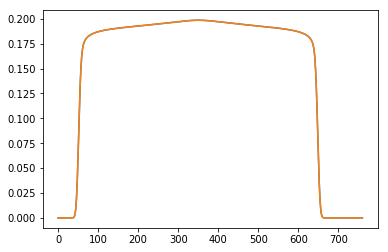

In [104]:
gate_time,SRATE,f_term,factor_r,T_reflec=(60e-9,10e9,1,0,2e-9)
lamb1 = [-0.11]

total_len = gate_time + 8e-9+4*T_reflec

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Slepian',t0=gate_time/2+10e-9/2,width=gate_time,amplitude=-40e6,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([10.2]),
              Coupling=12.2e6*np.sqrt(2),Offset=1.25e9,dfdV=6.5e9,negative_amplitude=True)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflec))
flux_pulse2=Seq.get_sequence()
plt.plot(flux_pulse1)
plt.plot(flux_pulse2)